In [1]:
import sqlite3
import pandas as pd
import numpy as np
import os
import polars as pl

import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../networks')
from dotenv import load_dotenv

import plotly.express as px

In [2]:
# Load the environment variables from the .env file
dotenv_path = os.path.join('../', '.env')
load_dotenv(dotenv_path)

True

In [3]:
from region_filters import (
    columns_eu,
    columns_non_eu,
    columns_non_eu_unique,
    columns_eu_unique,
)

columns_to_keep = columns_non_eu_unique + columns_eu_unique

In [4]:
from functions.env import DB_SCIENCE_PATH

conn = sqlite3.connect(DB_SCIENCE_PATH)
conn_full_db = sqlite3.connect(os.getenv("FULL_DB_PATH"))

df_occupation = pd.read_sql("SELECT * FROM individual_id_cleaned_occupations", conn)


df_ind_regions = pd.read_sql_query(
        "SELECT * FROM individuals_regions", conn_full_db
    )
df_ind_regions = df_ind_regions.rename(
        columns={"individual_wikidata_id": "wikidata_id"}
    )

df_indi = pd.merge(df_occupation, df_ind_regions, on = 'wikidata_id', how = 'left')
df_indi = df_indi[['wikidata_id', 'region_code']].drop_duplicates()

data_all = pd.read_sql_query(
        "SELECT * FROM temporal_data_clean", conn
    )
df_regions = pd.read_sql_query(
        "SELECT * FROM regions", conn_full_db
    )

df_regions = df_regions[df_regions['region_code']!='re_korea']

data_all = pd.merge(data_all,df_regions, on = 'region_code')
data_all = data_all[data_all['region_code'].isin(columns_to_keep)]
data_all = data_all.drop('region_code', axis=1)
data_all = data_all.rename(columns = {'region_name':'region_code'})

Get the % of occupation for each country by gicing the same weight to all regions

In [5]:
data_norm = data_all.groupby(['region_code', 'century', 'interest'])['wikidata_id'].count().reset_index()
data_norm.groupby('interest')['wikidata_id'].sum()
data_norm = data_norm[data_norm['wikidata_id']>=0]

count_all =  data_norm.groupby(['region_code', 'century'])['wikidata_id'].sum().rename('count_all').reset_index()
data_norm = pd.merge(data_norm, count_all, on = ['region_code', 'century'])
data_norm['percent'] = data_norm['wikidata_id']/data_norm['count_all']
data_norm.groupby('interest')['percent'].mean()

interest
Abstract Domain    0.621557
Human Domain       0.356995
Natural Domain     0.243513
Name: percent, dtype: float64

In [6]:
set(data_norm.region_code)

{'Arabic world',
 'Central Europe',
 'Chinese world',
 'France',
 'German world',
 'Greek World',
 'Indian world',
 'Italy',
 'Japan',
 'Low countries',
 'Nordic countries',
 'Persian world',
 'Slav world',
 'South East Asia',
 'Spain',
 'United Kingdom'}

In [7]:
data_all[['wikidata_id', 'interest']].drop_duplicates().interest.value_counts()

Natural Domain     10484
Abstract Domain     6498
Human Domain        6388
Name: interest, dtype: int64

In [8]:
final_pie = []
for region in data_norm['region_code'].unique():
    df_test = data_norm[data_norm['region_code']==region]
    interest_century_totals = df_test[['interest', 'century', 'percent']]
    interest_totals = interest_century_totals.groupby('interest')['percent'].mean().reset_index()
    interest_totals['percent'] = interest_totals['percent']/interest_totals['percent'].sum()
    interest_totals['region_code'] = region
    final_pie.append(interest_totals)
    
df_final_pie = pd.concat([x for x in final_pie])

In [9]:
import matplotlib.pyplot as plt

# Define a dictionary that maps interests to colors
interest_colors = {
    'Human Domain': '#1f77b4',
    'Abstract Domain': '#ff7f0e',
    'Natural Domain': '#2ca02c',
    # Add more interests and colors as needed
}

regions = list(set(df_final_pie.region_code))

final = []
for region in regions:
    test = df_final_pie[df_final_pie['region_code'] == region]
    test = test.set_index('interest')
    final.append({'region':region, 'dis':test['percent'].to_dict()})

In [10]:
dis_list = [ x['dis'] for x in final]
dis_list = [list(x.values()) for x in dis_list]

In [11]:
#Order : Abstract, Human, Natural

In [12]:
abtract_list = [x[0] for x in dis_list]
abtract_list = [x*100 for x in abtract_list]

human_list = [x[1] for x in dis_list]
human_list = [x*100 for x in human_list]

natural_list = [x[2] for x in dis_list]
natural_list = [x*100 for x in natural_list]

print(round(np.var(abtract_list), 1))
print(round(np.var(human_list), 1))
print(round(np.var(natural_list), 1))

98.4
66.2
49.6


In [13]:
print(round(np.std(abtract_list), 1))
print(round(np.std(human_list), 1))
print(round(np.std(natural_list), 1))

9.9
8.1
7.0


In [14]:
print(round(np.mean(abtract_list), 1))
print(round(np.mean(human_list), 1))
print(round(np.mean(natural_list), 1))

48.3
30.6
21.2


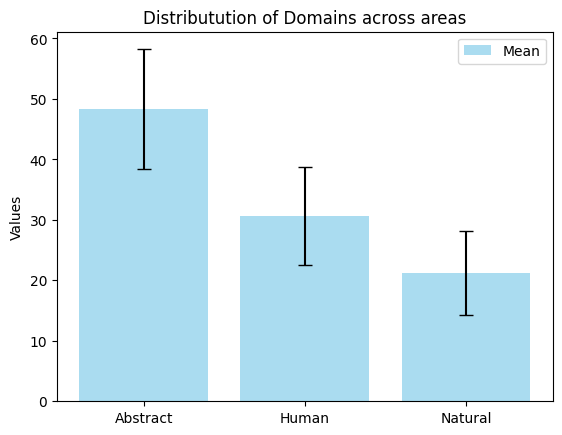

In [28]:
import matplotlib.pyplot as plt

# Data
labels = ["Abstract", "Human", "Natural"]

means = [round(np.mean(abtract_list), 1), round(np.mean(human_list), 1), round(np.mean(natural_list), 1)]
std_devs = [round(np.std(abtract_list), 1), round(np.std(human_list), 1), round(np.std(natural_list), 1)]


# Plotting
fig, ax = plt.subplots()

# Bar plot for means
ax.bar(labels, means, yerr=std_devs, capsize=5, color='skyblue', label='Mean', alpha=0.7)

# Adding labels and title
ax.set_ylabel('Values')
ax.set_title('Distributution of Domains across areas')
ax.legend()

# Show the plot
plt.show()

In [15]:
# Abstract / Human

diffs = []

for x in dis_list:
    diff = abs(x[0] - x[1])
    diffs.append(diff)
diffs = [x*100 for x in diffs]   
print(round(np.mean(diffs), 1))
diffs

22.4


[30.635906284284165,
 30.116472545757077,
 13.617364206958909,
 14.561274092245494,
 40.014416276797235,
 28.319887730155145,
 28.252524396099787,
 27.77777777777778,
 7.557051314591462,
 15.590996116735795,
 31.730652823358092,
 23.30839792640542,
 8.799243657519101,
 17.621564931870815,
 30.524432764261753,
 9.778555082181201]

In [16]:
# Abstract / Natural

diffs = []

for x in dis_list:
    diff = abs(x[0] - x[2])
    diffs.append(diff)
diffs = [x*100 for x in diffs]   
print(round(np.mean(diffs), 1))
diffs

27.8


[22.46283032983155,
 37.10482529118136,
 36.00146831441969,
 3.628364396177264,
 55.278870440334806,
 23.48911750795157,
 43.47929177083252,
 5.555555555555553,
 30.243866085883976,
 21.04149966972957,
 30.018741905113945,
 20.762969695880745,
 27.08735768617274,
 26.520449388714308,
 49.150790864443366,
 12.888293888722163]

In [17]:
# Human / Natural
diffs = []

for x in dis_list:
    diff = abs(x[1] - x[2])
    diffs.append(diff)
diffs = [x*100 for x in diffs]   
print(round(np.mean(diffs), 1))
diffs

12.9


[8.17307595445261,
 6.988352745424289,
 22.38410410746078,
 10.93290969606823,
 15.264454163537572,
 4.830770222203578,
 15.226767374732727,
 22.222222222222225,
 22.686814771292514,
 5.450503552993776,
 1.7119109182441472,
 2.545428230524674,
 18.28811402865364,
 8.898884456843492,
 18.626358100181612,
 22.666848970903363]

Nature-Inspired Colors:

Forest Green: #023047
Earthy Brown: #7A9B76
Sky Blue: #98C1D9

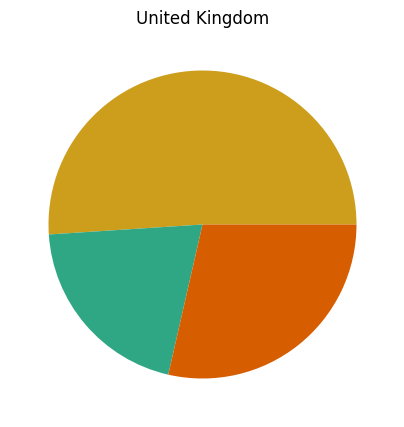

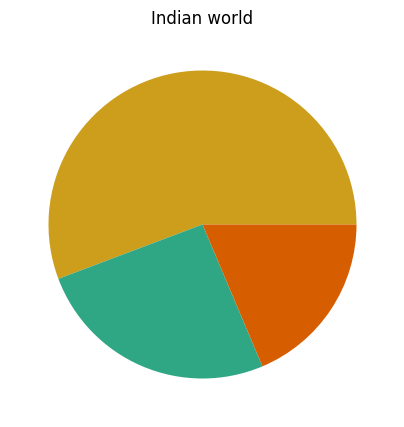

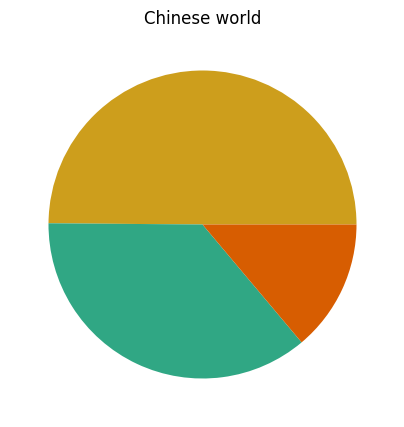

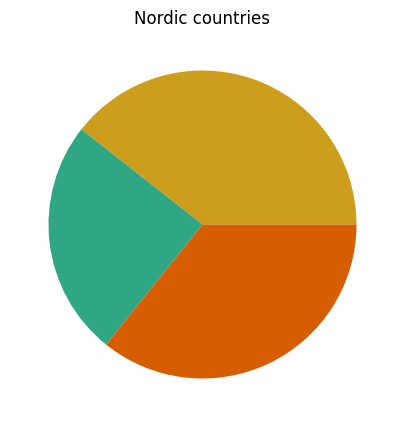

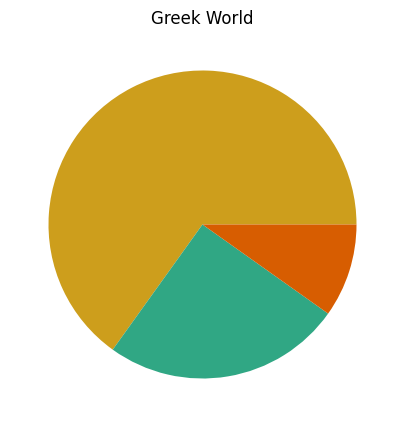

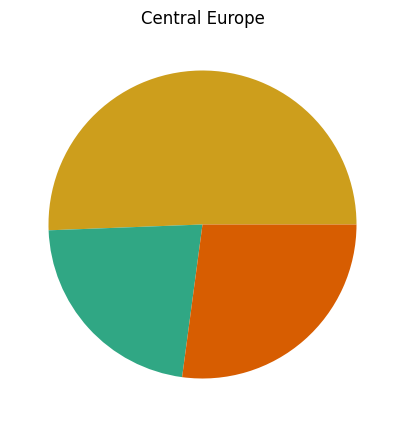

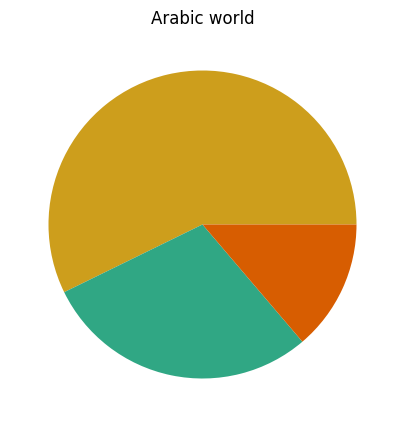

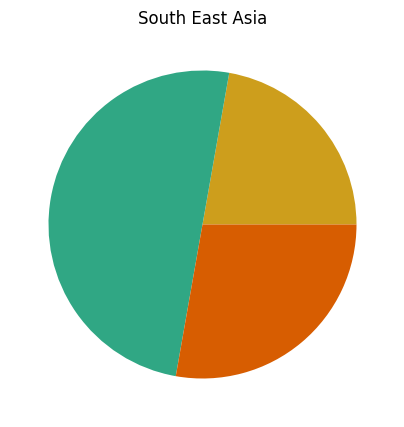

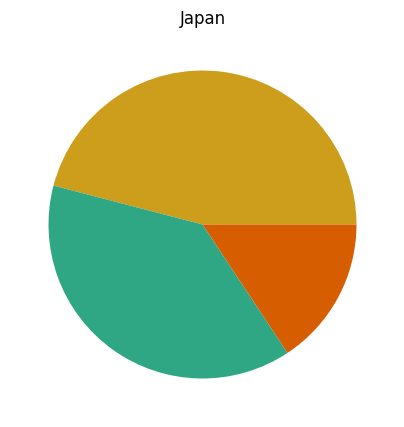

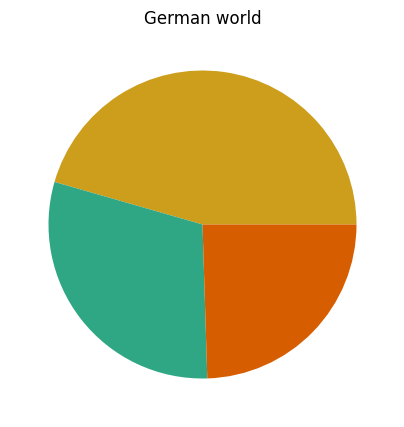

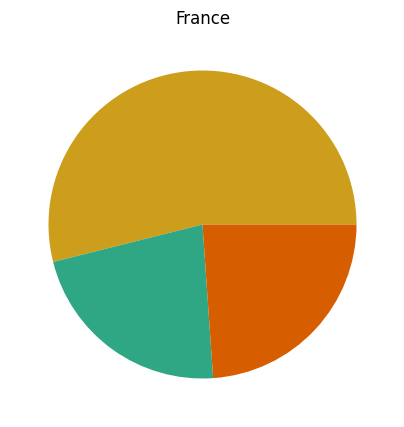

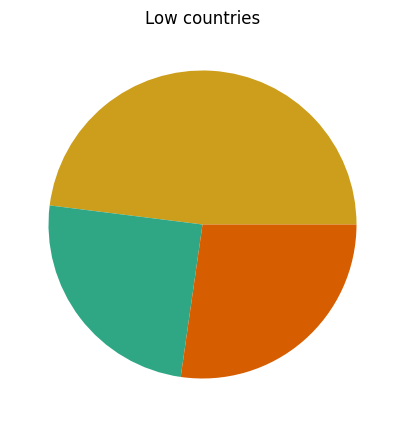

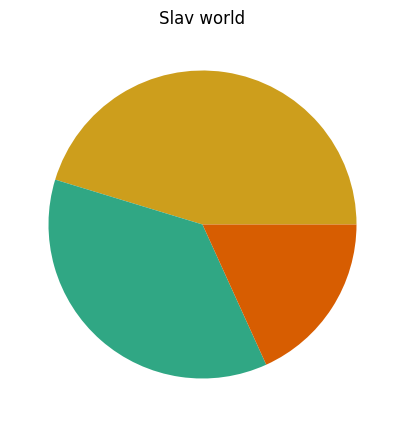

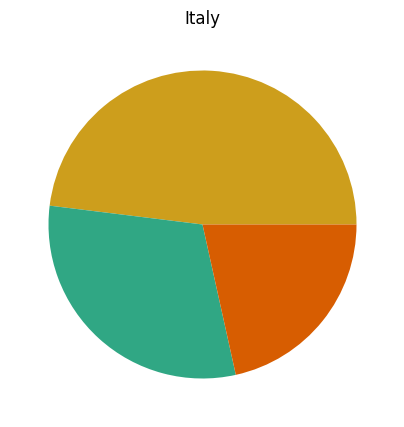

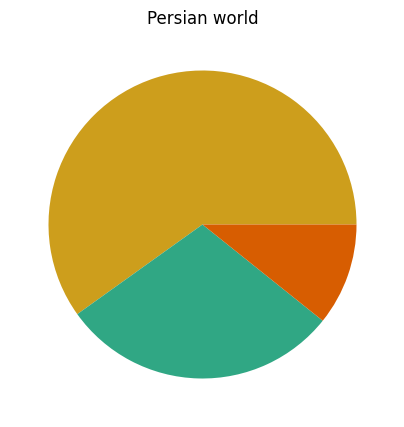

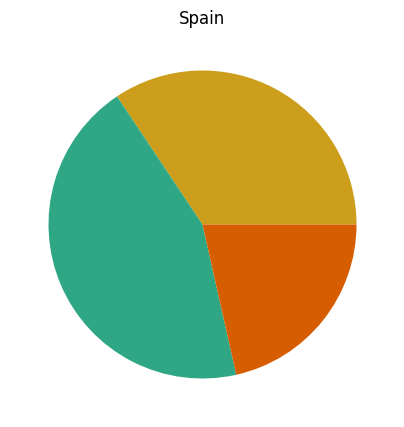

In [18]:
import matplotlib.pyplot as plt

# Define a dictionary that maps interests to colors
interest_colors = {
    'Human Domain': '#1f77b4',
    'Abstract Domain': '#ff7f0e',
    'Natural Domain': '#2ca02c',
    # Add more interests and colors as needed
}

# Define a dictionary that maps interests to colors
interest_colors = {
    'Human Domain': '#30a784',
    'Abstract Domain': '#cd9e1c',
    'Natural Domain': '#d75d01',
    # Add more interests and colors as needed
}

regions = list(set(df_final_pie.region_code))

final = []
for region in regions:
    test = df_final_pie[df_final_pie['region_code'] == region]
    test = test.set_index('interest')
    final.append(test)
    
    # Assign colors to interests based on the dictionary
    colors = [interest_colors.get(interest, 'gray') for interest in test.index]
    
    plot = test.plot.pie(y='percent', 
                         figsize=(5, 5), 
                         title=region, 
                         colors=colors, 
                         legend=False, 
                         labels = None)
                        #autopct='%1.1f%%')
    plot.set_ylabel('')
    plot.figure.savefig(f"pie_figures/{region}.png", transparent=True)

plt.show()

### Stats with distribution

In [19]:
df = data_all[['wikidata_id', 'region_code', 'interest']].drop_duplicates()
df = df.groupby(['region_code', 'interest'])['wikidata_id'].count().reset_index()

df_count = df.groupby('region_code')['wikidata_id'].sum().reset_index()
df_count.columns = ['region_code', 'total']
final_df = pd.merge(df, df_count, on = 'region_code')
final_df['percent'] = final_df['wikidata_id']/final_df['total']
final_df = final_df[final_df['region_code'].isin(columns_to_keep)]

In [20]:
import matplotlib.pyplot as plt
from itertools import cycle

# Define a list of nice colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

regions = list(set(final_df.region_code))
color_cycle = cycle(colors)

for region in regions:
    test = final_df[final_df['region_code'] == region]
    test = test.set_index('interest')
    plot = test.plot.pie(y='percent', figsize=(5, 5), title=region, colors=[next(color_cycle) for _ in range(len(test))])
    plot.figure.savefig(f"pie_figures/{region}.png")

plt.show()


#### Geopandas

In [21]:
import pandas as pd

data = pd.DataFrame({
    'name': ['Fiji', 'Tanzania', 'Canada'],
    'Latitude': [44, 33, 11],  # Replace with actual coordinates
    'Longitude': [123, 34, 160],  # Replace with actual coordinates
    'Value1': [30, 50, 20],  # Values for the first category
    'Value2': [40, 20, 10],  # Values for the second category
    # Add more categories as needed
})

In [22]:
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_42473/2162896047.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [23]:
merged_data = world.merge(data, on='name')

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
world.boundary.plot(ax=ax, linewidth=1, color='black')  # Plot country boundaries


# Plot pie charts on the main regions
for x, y, region, val1, val2 in zip(merged_data['Longitude'], merged_data['Latitude'],
                                    merged_data['name'], merged_data['Value1'], merged_data['Value2']):
    ax.annotate(region, xy=(x, y), fontsize=10, ha='center', va='center')
    ax.pie([val1, val2], center=(x, y), radius=0.2, startangle=90, colors=['#ff9999', '#66b3ff'],
           autopct='%1.1f%%', pctdistance=0.85)
    
plt.show()

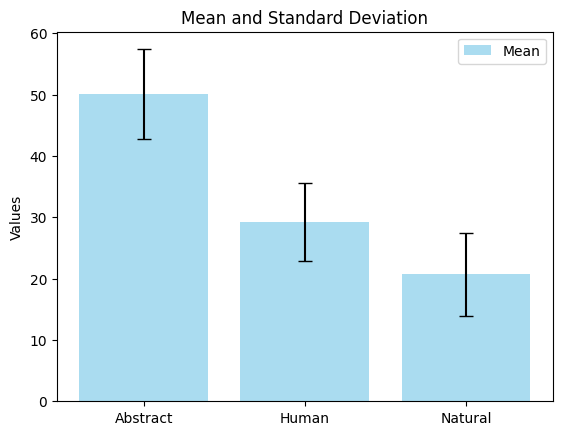